# IOOS Interface Demo Notebook

This notebook will walk through a demo of how to use the IOOS interface of the LTER-IOOS data-merge project. Several features of the interface include:
* Abstracted selection of quantities of interest (temperature, salinity, etc)
* Option to select observations or models for displaying
* An interface for interacting with models

## Preamble
Helper downloads for this notebook

In [1]:
%matplotlib inline

# Basic packages
import numpy as np 
import pandas as pd 
import geopandas as gpd
from datetime import datetime, timedelta
import re
from itertools import cycle
from netCDF4 import Dataset
import gridgeo
import copy
import xarray as xr

# Visualizers
import matplotlib.pyplot as plt 
import matplotlib
import folium
import shapely.geometry as shpgeom 
import cartopy.crs as ccrs
from cartopy.io.img_tiles import StamenTerrain
import altair as alt
import vega

# IOOS Library Package and Geotools
from owslib import fes
from ioos_tools.ioos import fes_date_filter, get_csw_records
from owslib.csw import CatalogueServiceWeb
from geolinks import sniff_link

In [2]:
# Local library in this repository for helpful interface functions
import sys
sys.path.append("../ohw_lter_vis") # go to parent dir
from ioos_lib import *

## The DataScraper Object
The IOOS interface is encoded as an **object** which has a number of **methods** to do the types of processing you need. The parameters that need to be set when making a DataScraper object are:
* Bounding Box (spatial region of interest)
* Start time
* End time
* Labels to search for
* Boolean of whether or not to pull models or observations

In [3]:
# Let's fetch some labels; a helper function is provided
labels = fetch_labels('salinity')

# Let's establish a date range of interest; a helper function is provided
# PLEASE NOTE! The IOOS restricts data fetching windows to 30 days
start, stop = fetch_dates(start_year=2016, start_month=4, start_day=19, duration=25)

# Let's establish our ROI [min_lon, max_lon, min_lat, max_lat]
roi = [-72, -69, 38.5, 41]

# Finally, let's make our scraper; focusing on observations at first
ds = DataScraper(roi, start, stop, labels, models_only=False)

## Checking and Adjusting
There are a few built-in tools for allowing you to check and adjust the status of your Data Scraper object -- particularly, displaying your ROI, date range, and the labels that you've accessed. Let's take a look below.

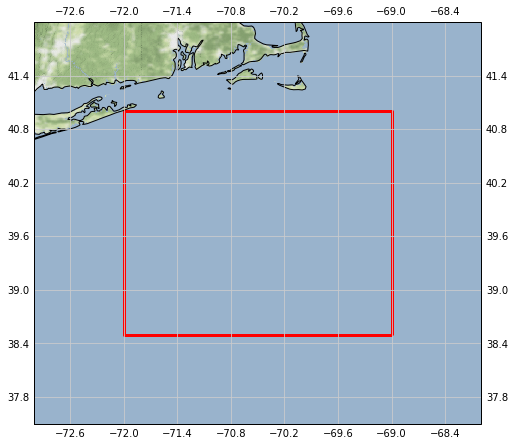

In [4]:
# Let's see our ROI
ds.draw_roi()
plt.show()

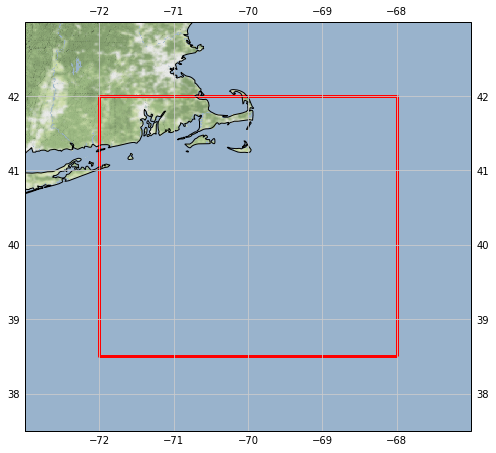

In [5]:
# Let's adjust our roi
ds.adjust_roi(max_lon=-68, max_lat=42)
ds.draw_roi()
plt.show()

In [6]:
# Let's check our date range
print(ds.start, ds.stop)

# And let's update it
new_start, new_stop = fetch_dates(2016, 4, 12, 30)
ds.update_date(new_start, new_stop)
print(ds.start, ds.stop)

2016-04-19 00:00:00 2016-05-14 00:00:00
2016-04-12 00:00:00 2016-05-12 00:00:00


In [7]:
# Finally, let's see what the actual labels are we are using, and change them
print(ds.target)
cls = copy.copy(ds.target)
ds.update_labels(cls+fetch_labels('temperature')) #adding the temperature labels too
print(ds.target)

['sea_water_salinity', 'sea_surface_salinity', 'sea_water_absolute_salinity', 'sea_water_cox_salinity', 'sea_water_knudsen_salinity', 'sea_water_practical_salinity', 'sea_water_preformed_salinity']
['sea_water_salinity', 'sea_surface_salinity', 'sea_water_absolute_salinity', 'sea_water_cox_salinity', 'sea_water_knudsen_salinity', 'sea_water_practical_salinity', 'sea_water_preformed_salinity', 'sea_water_temperature', 'sea_surface_temperature', 'sea_water_potential_temperature', 'equivalent_potential_temperature', 'sea_water_conservative_temperature', 'pseudo_equivalent_potential_temperature']


## Observation Parsing
Wonderful, so now that we can see and adjust our paramters for running our IOOS basic interface, let's do a little bit of science with it. Let's go ahead now, and pull in some observations, based on the parameters which we've specified.

In [8]:
# First, let's query for records
ds.get_records()

# We can inspect these records by printing them to terminal
ds.pretty_print_records()

Found 29 records.

UNH_WBD

opendap.co-ops.nos.noaa.gov-urn_ioos_station_NOAA.NOS.CO-OPS_8447386

opendap.co-ops.nos.noaa.gov-urn_ioos_station_NOAA.NOS.CO-OPS_8447435

opendap.co-ops.nos.noaa.gov-urn_ioos_station_NOAA.NOS.CO-OPS_8447930

opendap.co-ops.nos.noaa.gov-urn_ioos_station_NOAA.NOS.CO-OPS_8449130

opendap.co-ops.nos.noaa.gov-urn_ioos_station_NOAA.NOS.CO-OPS_8452660

opendap.co-ops.nos.noaa.gov-urn_ioos_station_NOAA.NOS.CO-OPS_8452944

opendap.co-ops.nos.noaa.gov-urn_ioos_station_NOAA.NOS.CO-OPS_8454000

opendap.co-ops.nos.noaa.gov-urn_ioos_station_NOAA.NOS.CO-OPS_8454049

opendap.co-ops.nos.noaa.gov-urn_ioos_station_NOAA.NOS.CO-OPS_8510560

URI_168-MV_BottomSonde

URI_168-MV_SurfaceSonde

edu.ncsu.meas:cnaps

org.oceanobservatories:cp_335-20160404T1857_f070_8f49_1646

cp_335-20160404T1857

cp_339-20160121T1629

org.oceanobservatories:cp_339-20160121T1629_f070_8f49_1646

cp_379-20160121T1500

org.oceanobservatories:cp_379-20160121T1500_f070_8f49_1646

cp_387-20160404T1858

org.

Unfortunately, this doesn't necessarily tell us a lot, but we can carry forward and see what happens when we query these files. Let's create our initial database which we'll use to access the data. THIS DOES NOT PULL DATA YET!

In [9]:
ds.create_database()
ds.df.head(5)

scheme                                                url  \
0            order  http://www.neracoos.org/erddap/tabledap/UNH_WB...   
1            order  http://www.neracoos.org/erddap/tabledap/UNH_WB...   
2  ERDDAP:tabledap    http://www.neracoos.org/erddap/tabledap/UNH_WBD   
3  OPeNDAP:OPeNDAP    http://www.neracoos.org/erddap/tabledap/UNH_WBD   
4           search  http://www.neracoos.org/erddap/tabledap/UNH_WB...   

    geolink  
0  WWW:LINK  
1      None  
2      None  
3      None  
4      None

Great! So we see that we've been able to generate urls to fetch data, we've pulled out schemes, and we've been able to generate geolinks for the things that exist for that. When we go to pull observations, we'll make sure to fix anything that doesn't have a geolink when we access the meta data. Let's pull our observations.

In [10]:
obs_df = ds.get_observations(silent=False) #you can choose whether or not to print these messages to terminal
obs_df.head(5)

Processing: http://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/SOS?eventTime=2016-04-12T00:04:00/2016-05-12T00:05:00&request=GetObservation&version=1.0.0&responseFormat=text/csv&offering=urn:ioos:station:NOAA.NOS.CO-OPS:8447386&service=SOS&observedProperty=http://mmisw.org/ont/cf/parameter/air_pressure
Processing: http://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/SOS?eventTime=2016-04-12T00:04:00/2016-05-12T00:05:00&request=GetObservation&version=1.0.0&responseFormat=text/csv&offering=urn:ioos:station:NOAA.NOS.CO-OPS:8447386&service=SOS&observedProperty=http://mmisw.org/ont/cf/parameter/air_temperature
Processing: http://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/SOS?eventTime=2016-04-12T00:04:00/2016-05-12T00:05:00&request=GetObservation&version=1.0.0&responseFormat=text/csv&offering=urn:ioos:station:NOAA.NOS.CO-OPS:8447386&service=SOS&observedProperty=http://mmisw.org/ont/cf/parameter/sea_surface_height_amplitude_due_to_equilibrium_ocean_tide
Processing: http://opendap.co-ops.nos.noaa.gov/i

Processing: http://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/SOS?eventTime=2016-04-12T00:04:00/2016-05-12T00:05:00&request=GetObservation&version=1.0.0&responseFormat=text/csv&offering=urn:ioos:station:NOAA.NOS.CO-OPS:8452660&service=SOS&observedProperty=http://mmisw.org/ont/cf/parameter/sea_water_salinity
Processing: http://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/SOS?eventTime=2016-04-12T00:04:00/2016-05-12T00:05:00&request=GetObservation&version=1.0.0&responseFormat=text/csv&offering=urn:ioos:station:NOAA.NOS.CO-OPS:8452660&service=SOS&observedProperty=http://mmisw.org/ont/cf/parameter/sea_water_temperature
Processing: http://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/SOS?eventTime=2016-04-12T00:04:00/2016-05-12T00:05:00&request=GetObservation&version=1.0.0&responseFormat=text/csv&offering=urn:ioos:station:NOAA.NOS.CO-OPS:8452660&service=SOS&observedProperty=http://mmisw.org/ont/cf/parameter/water_surface_height_above_reference_datum
Processing: http://opendap.co-ops.nos.noaa.gov/ioos-

Processing: http://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/SOS?eventTime=2016-04-12T00:04:00/2016-05-12T00:05:00&request=GetObservation&version=1.0.0&responseFormat=text/csv&offering=urn:ioos:station:NOAA.NOS.CO-OPS:8454049&service=SOS&observedProperty=http://mmisw.org/ont/cf/parameter/sea_water_temperature
Processing: http://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/SOS?eventTime=2016-04-12T00:04:00/2016-05-12T00:05:00&request=GetObservation&version=1.0.0&responseFormat=text/csv&offering=urn:ioos:station:NOAA.NOS.CO-OPS:8454049&service=SOS&observedProperty=http://mmisw.org/ont/cf/parameter/water_surface_height_above_reference_datum
Processing: http://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/SOS?eventTime=2016-04-12T00:04:00/2016-05-12T00:05:00&request=GetObservation&version=1.0.0&responseFormat=text/csv&offering=urn:ioos:station:NOAA.NOS.CO-OPS:8454049&service=SOS&observedProperty=http://mmisw.org/ont/cf/parameter/wind_from_direction
Processing: http://opendap.co-ops.nos.noaa.gov/ioos

/home/vpreston/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


LAT/HAT_Datum_Confidence_Lvl(days_data_record_analysed)  \
date_time                                                                     
2016-04-12 00:06:00                                                NaN        
2016-04-12 00:12:00                                                NaN        
2016-04-12 00:18:00                                                NaN        
2016-04-12 00:24:00                                                NaN        
2016-04-12 00:30:00                                                NaN        

                     air_pressure (mb)  air_temperature (C) datum_id epoch  \
date_time                                                                    
2016-04-12 00:06:00             1020.1                  NaN      NaN   NaN   
2016-04-12 00:12:00             1020.0                  NaN      NaN   NaN   
2016-04-12 00:18:00             1020.0                  NaN      NaN   NaN   
2016-04-12 00:24:00             1019.9                  NaN      NaN   NaN   
2016-04-12 00:30:00             1019.8                  NaN      NaN   NaN   

                     highest_astronomical_tide (m)  latitude (degree)  \
date_time                                                               
2016-04-12 00:06:00                            NaN            41.7043   
2016-04-12 00:12:00                            NaN            41.7043   
2016-04-12 00:18:00                            NaN            41.7043   
2016-04-12 00:24:00                            NaN            41.7043   
2016-04-12 00:30:00                            NaN            41.7043   

                     longitude (degree)  lowest_astronomical_tide (m)  \
date_time                                                               
2016-04-12 00:06:00            -71.1641                           NaN   
2016-04-12 00:12:00            -71.1641                           NaN   
2016-04-12 00:18:00            -71.1641                           NaN   
2016-04-12 00:24:00            -71.1641                           NaN   
2016-04-12 00:30:00            -71.1641                           NaN   

                    quality_flags         ...          \
date_time                                 ...           
2016-04-12 00:06:00         0;0;0         ...           
2016-04-12 00:12:00         0;0;0         ...           
2016-04-12 00:18:00         0;0;0         ...           
2016-04-12 00:24:00         0;0;0         ...           
2016-04-12 00:30:00         0;0;0         ...           

                     sea_water_temperature (C)  \
date_time                                        
2016-04-12 00:06:00                        NaN   
2016-04-12 00:12:00                        NaN   
2016-04-12 00:18:00                        NaN   
2016-04-12 00:24:00                        NaN   
2016-04-12 00:30:00                        NaN   

                                                      sensor_id  sigma  \
date_time                                                                
2016-04-12 00:06:00  urn:ioos:sensor:NOAA.NOS.CO-OPS:8447386:F1    NaN   
2016-04-12 00:12:00  urn:ioos:sensor:NOAA.NOS.CO-OPS:8447386:F1    NaN   
2016-04-12 00:18:00  urn:ioos:sensor:NOAA.NOS.CO-OPS:8447386:F1    NaN   
2016-04-12 00:24:00  urn:ioos:sensor:NOAA.NOS.CO-OPS:8447386:F1    NaN   
2016-04-12 00:30:00  urn:ioos:sensor:NOAA.NOS.CO-OPS:8447386:F1    NaN   

                                                   station_id  \
date_time                                                       
2016-04-12 00:06:00  urn:ioos:station:NOAA.NOS.CO-OPS:8447386   
2016-04-12 00:12:00  urn:ioos:station:NOAA.NOS.CO-OPS:8447386   
2016-04-12 00:18:00  urn:ioos:station:NOAA.NOS.CO-OPS:8447386   
2016-04-12 00:24:00  urn:ioos:station:NOAA.NOS.CO-OPS:8447386   
2016-04-12 00:30:00  urn:ioos:station:NOAA.NOS.CO-OPS:8447386   

                    vertical_position (m)  \
date_time                                   
2016-04-12 00:06:00                   NaN   
2016-04-12 00:12:00               

In the event that observations do not exist for our target area, then a message will display, and we can adjust our search terms.

We also get out a massive dataframe of the query data, concatenated together. If you'd like to just see a list of all of the idividual dataframes, you can access the ```ds.observations``` object.

So we now have a single dataframe with everything smooshed together. Let's see if we can make sense of the data, by doing a little simple plotting.

Index(['LAT/HAT_Datum_Confidence_Lvl(days_data_record_analysed)',
       'air_pressure (mb)', 'air_temperature (C)', 'datum_id', 'epoch',
       'highest_astronomical_tide (m)', 'latitude (degree)',
       'longitude (degree)', 'lowest_astronomical_tide (m)', 'quality_flags',
       'sea_surface_height_amplitude_due_to_equilibrium_ocean_tide (m)',
       'sea_water_electrical_conductivity (mS/cm)', 'sea_water_salinity (psu)',
       'sea_water_temperature (C)', 'sensor_id', 'sigma', 'station_id',
       'vertical_position (m)',
       'water_surface_height_above_reference_datum (m)',
       'wind_from_direction (degree)', 'wind_speed (m/s)',
       'wind_speed_of_gust (m/s)', 'time'],
      dtype='object')


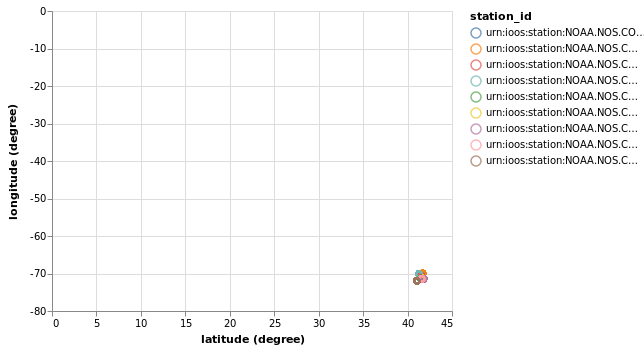

In [11]:
alt.renderers.enable('notebook')
print(obs_df.columns)
alt.Chart(obs_df[0::100]).mark_point().encode(x='latitude (degree)', y='longitude (degree)', color='station_id')

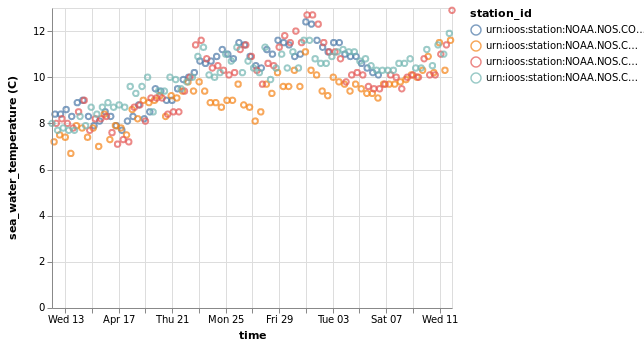

In [12]:
m = alt.Chart(obs_df[0::100]).mark_point().encode(x='time:T', y='sea_water_temperature (C)', color='station_id')
m

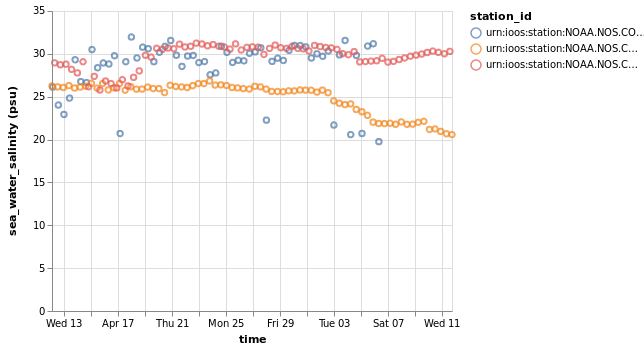

In [13]:
s = alt.Chart(obs_df[0::100]).mark_point().encode(x='time:T', y='sea_water_salinity (psu)', color='station_id')
s

## Model Parsing
Sometimes all we care about is accessing models, and not observations. We can do that too, with a few simple changes to our parser. Let's make a new one and check it out.

In [3]:
# Let's fetch some labels; a helper function is provided
labels = fetch_labels('temperature')

# Let's establish a date range of interest; a helper function is provided
# PLEASE NOTE! The IOOS restricts data fetching windows to 30 days
start, stop = fetch_dates(start_year=2016, start_month=4, start_day=19, duration=25)

# Let's establish our ROI [min_lon, max_lon, min_lat, max_lat]
roi = [-72, -68, 38.5, 41]

# Finally, let's make our scraper; focusing on observations at first
mod_ds = DataScraper(roi, start, stop, labels, models_only=True)

In [4]:
# Let's get the records and make the database
mod_ds.get_records()
mod_ds.create_database()
mod_ds.df.head(5)

Found 8 records.



scheme                                                url  \
0         WWW:LINK  http://thredds.secoora.org/thredds/dodsC/SECOO...   
1         WWW:LINK  http://www.ncdc.noaa.gov/oa/wct/wct-jnlp-beta....   
2  OPeNDAP:OPeNDAP  http://thredds.secoora.org/thredds/dodsC/SECOO...   
3          OGC:WCS  http://thredds.secoora.org/thredds/wcs/SECOORA...   
4          OGC:WMS  https://data.axds.co/ncWMS/wms?service=WMS&ver...   

    geolink  
0  WWW:LINK  
1      None  
2      None  
3   OGC:WCS  
4   OGC:WMS

In [5]:
# Finally, let's grab the model urls
mod_ds.get_models()
print(mod_ds.model_urls)

{'Coupled Northwest Atlantic Prediction System (CNAPS)': <GridGeo: unknown_2d>, 'Daily MUR SST, Interim near-real-time (nrt) product': <GridGeo: unknown_1d>, 'ROMS ESPRESSO Real-Time Operational IS4DVAR Forecast System Version 2 (NEW) 2013-present FMRC Averages': <GridGeo: sgrid>, 'ROMS ESPRESSO Real-Time Operational IS4DVAR Forecast System Version 2 (NEW) 2013-present FMRC History': <GridGeo: sgrid>, 'silbo-20160413T1534': <GridGeo: unknown_2d>, 'South Atlantic Bight and Gulf of Mexico (SABGOM)': <GridGeo: unknown_2d>}
['http://thredds.secoora.org/thredds/dodsC/SECOORA_NCSU_CNAPS.nc', 'http://tds.maracoos.org/thredds/dodsC/MURSST/2016/Agg', 'http://tds.marine.rutgers.edu/thredds/dodsC/roms/espresso/2013_da/avg/ESPRESSO_Real-Time_v2_Averages_Best', 'http://tds.marine.rutgers.edu/thredds/dodsC/roms/espresso/2013_da/his/ESPRESSO_Real-Time_v2_History_Best', 'http://data.ioos.us/thredds/dodsC/deployments/rutgers/silbo-20160413T1534/silbo-20160413T1534.nc3.nc', 'http://thredds.secoora.org/t

We now have the grids for the models stored, but we haven't downloaded any data per se. If you'd like to see the extent of these models, you can generate an extent map like the one below.

In [ ]:
# Heads up! This will take a fair while to run. Use caution!
tiles = 'http://services.arcgisonline.com/arcgis/rest/services/Ocean/World_Ocean_Base/MapServer/tile/{z}/{y}/{x}'
m = folium.Map(tiles=tiles, attr='ESRI')
for title, grid in mod_ds.grids.items():
    try:
        print('Loading...')
        gj = folium.GeoJson(grid.outline.__geo_interface__, name=title)
        folium.Popup(title).add_to(gj)
        gj.add_to(m)
    except Exception:
        print(f'Could not compute grid outline for {title}')
m

Loading...
Loading...


But ultimately, we want to do some interesting work with these datasets. We can use the list of urls to access these datasets, take a look at the formatting, and then determine whether the model is suitable for our purposes. We can plot the extents as is, or we can query specific points; which may be interesting for interfacing with LTER or other instruments. Let's first take a look at just plotting the models.

In [6]:
# Let's get some salinity 
salty = mod_ds.open_models(param_of_interest='salt', date_of_interest=start)

here


Now we have a list of valid models with salinity data -- excellent! Let's inspect it a bit.

In [7]:
salty

[<xarray.DataArray 'salt' (time: 1, eta_rho: 82, xi_rho: 130)>
 array([[[36.438427, 36.423733, ..., 35.44686 , 35.38819 ],
         [36.453117, 36.39807 , ..., 35.411385, 35.329517],
         ...,
         [      nan,       nan, ...,       nan,       nan],
         [      nan,       nan, ...,       nan,       nan]]], dtype=float32)
 Coordinates:
     s_rho     float64 -0.01389
     lon_rho   (eta_rho, xi_rho) float64 ...
     lat_rho   (eta_rho, xi_rho) float64 ...
   * time      (time) datetime64[ns] 2016-04-19
     time_run  (time) datetime64[ns] ...
 Dimensions without coordinates: eta_rho, xi_rho
 Attributes:
     long_name:      salinity
     time:           ocean_time
     field:          salinity, scalar, series
     _ChunkSizes:    [  1  36  82 130]
     standard_name:  sea_water_salinity]

And since these models are xarrays, we can do some clever plotting with them to check them out.

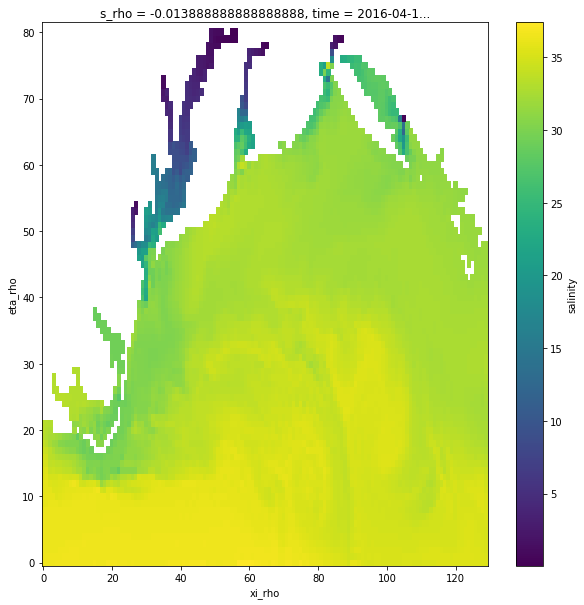

In [8]:
salty[0].plot(figsize=(10,10))

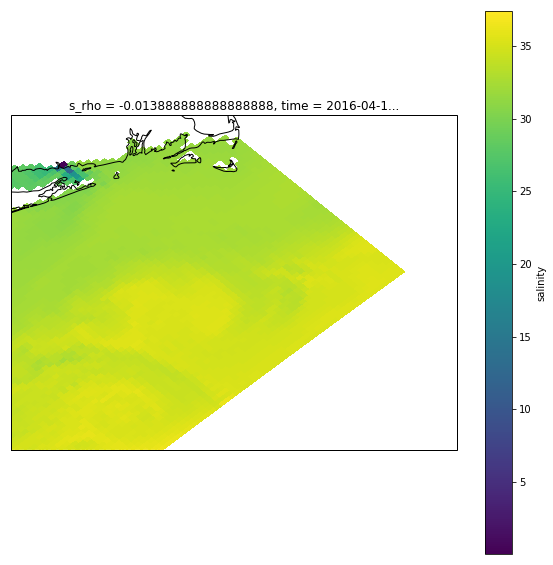

In [10]:
fig, ax = plt.subplots(
    figsize=(10, 10),
    subplot_kw={'projection': ccrs.PlateCarree()}
)
salty[0].plot(x='lon_rho', y='lat_rho',
    ax=ax,
    transform=ccrs.PlateCarree()
)
ax.set_extent((mod_ds.min_lon-1, mod_ds.max_lon+1, mod_ds.min_lat-1, mod_ds.max_lat+1))
ax.coastlines('10m');

## Wrapping Up
Great! You've now seen all of the basic functionality of this IOOS Datascraper object. With it, you can:
* establish an ROI for querying observation and model data
* establish a date range of interest
* search for specific parameters of interest
* get a pandas dataframe of relevant observations for you to parse further
* get a list of xarrays of models for you to parse further
* get lists of URLS of raw datasets that you may want to process yourself with your secret sauce

This notebook also demonstrates a few of the simple plotting tools you can use to actually examine your data and explore. Good luck, and happy science!